In [360]:
%pylab inline
import warnings
warnings.filterwarnings("ignore")
import nolearn
from nolearn.lasagne import NeuralNet
from progress_bar1 import ProgressBar
import createdb as cdb
import lasagne
from lasagne import layers
from sklearn import metrics
import detectobjects as det

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [355]:
opts = {'img_dir': 'image_dir2/',
        'models_dir': '../models/',
        'annotation_dir': 'annotation_dir2/',
        'train-dir': 'train_dir/',
        'test-dir': 'test_dir/',
        'val-dir': 'val_dir/',
        'patches_dir': 'patches_dir/',
        'augment-training-data': False,
        'model': '2C-1FC-O',
        'threshold': 0.8, 
        'overlapThreshold': 0.3, 
        'lim': 0, 
        'gauss': 1,
        'prob': det.MAX, 
        'pos': det.MAX, 
        'probs_area': 90,
        'input_scale': None,
        'raw_scale': 255,
        'image_dims': (160,160),
        'image_downsample' : 8,
        'patch_stride_training' : 40,
        'channel_swap': None,
        'probs_area': 40,
        'detection-step': 15,
        'patch-creation-step': 40,
       }

In [310]:
trainfiles, valfiles, testfiles = cdb.create_sets(opts['img_dir'], train_set_proportion=.7, 
                                                  test_set_proportion=.29,
                                                  val_set_proportion=.01)

train_y, train_X = cdb.create_patches_at_center(trainfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])
test_y, test_X = cdb.create_patches_at_center(testfiles,  opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])
val_y, val_X = cdb.create_patches_at_center(valfiles, opts['annotation_dir'], opts['img_dir'], opts['image_dims'][0], opts['patch_stride_training'], grayscale=False, progressbar=True, downsample=opts['image_downsample'])

# For training/validation, cut down on disproportionately large numbers of negative patches
train_X, train_y = cdb.balance(train_X, train_y, mult_neg=100)
val_X, val_y = cdb.balance(val_X, val_y, mult_neg=100)

# Create rotated and flipped versions of the positive patches
train_X, train_y = cdb.augment_positives(train_X, train_y)
val_X, val_y = cdb.augment_positives(val_X, val_y)
test_X, test_y = cdb.augment_positives(test_X, test_y)


[                  0%                  ]


### View a random selection of positive and negative patches to see if they look right

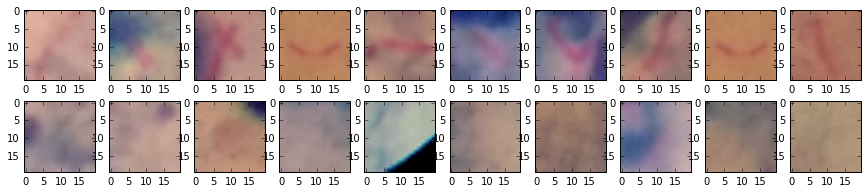

In [311]:
N_samples_to_display = 10
pos_indices = np.where(train_y)[0]
pos_indices = pos_indices[np.random.permutation(len(pos_indices))]
for i in range(N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_pos = train_X[pos_indices[i],:,:,:]
    example_pos = np.swapaxes(example_pos,0,2)
    plt.imshow(example_pos[:,:,[2,1,0]])
    
neg_indices = np.where(train_y==0)[0]
neg_indices = neg_indices[np.random.permutation(len(neg_indices))]
for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = train_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])
    
plt.gcf().set_size_inches(1.5*N_samples_to_display,3)

### CNN training

In [313]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
        
    input_shape=(None, 3, opts['image_dims'][0]/opts['image_downsample'], 
                 opts['image_dims'][0]/opts['image_downsample']),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify,
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters=12, 
    conv2_filter_size=(2, 2),    
    conv2_nonlinearity=lasagne.nonlinearities.rectify,
        
    hidden3_num_units=100,
    output_num_units=2, 
    output_nonlinearity=lasagne.nonlinearities.softmax,

    update_learning_rate=0.0001,
    update_momentum=0.9,

    max_epochs=n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(500).fit(train_X, train_y)

# Neural Network with 77646 learnable parameters

## Layer information

  #  name     size
---  -------  -------
  0  input    3x20x20
  1  conv1    7x18x18
  2  pool1    7x9x9
  3  conv2    12x8x8
  4  hidden3  100
  5  output   2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       1.65360       0.29783      5.55215      0.89808  0.51s
      2       0.27877       0.27874      1.00010      0.89733  0.50s
      3       0.26004       0.26556      0.97920      0.90237  0.50s
      4       0.24237       0.24279      0.99828      0.90892  0.50s
      5       0.22301       0.22043      1.01169      0.91195  0.50s
      6       0.20407       0.20294      1.00558      0.91472  0.50s
      7       0.18935       0.19122      0.99024      0.91799  0.50s
      8       0.17863       0.18286      0.97684      0.91875  0.50s
      9       0.17067       0.17634      0.96784      0.92077  0.51s
     10   

### Make predictions and evaluate on test data

In [314]:
y_pred = cnn.predict_proba(test_X)

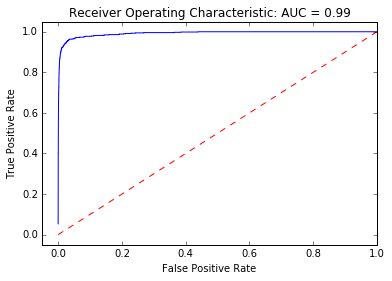

In [315]:
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(test_y, y_pred[:,1])
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic: AUC = %0.2f'% roc_auc)
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylim([-.05, 1.05])
plt.xlim([-.05, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

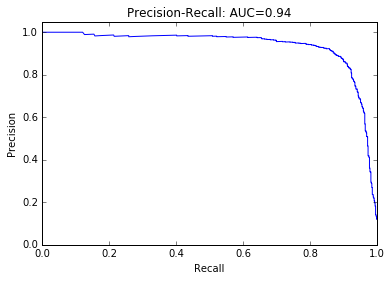

In [316]:
precision, recall, thresholds = metrics.precision_recall_curve(test_y, y_pred[:,1])
average_precision = metrics.average_precision_score(test_y, y_pred[:, 1])

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

### Examine mistakes to understand network performance - false positives
Find the negative-labelled patches with highest prediction score

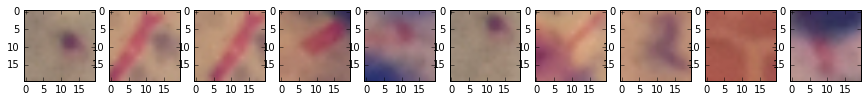

In [332]:
neg_indices = np.where(test_y==0)[0]
neg_scores = y_pred[neg_indices,1]
neg_indices = neg_indices[neg_scores.argsort()]
neg_indices = neg_indices[::-1]

neg_scores = y_pred[neg_indices,1]
neg_scores

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[neg_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

See highest-scored test patches

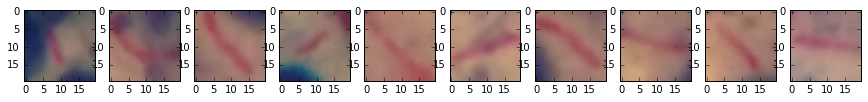

In [333]:
prob_range = [.9,1.]

tmp_scores = y_pred.copy()[:,1]
tmp_scores[tmp_scores<prob_range[0]] = -1
tmp_scores[tmp_scores>prob_range[1]] = -1

pos_indices = tmp_scores.argsort()
pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

Lowest scored test patches

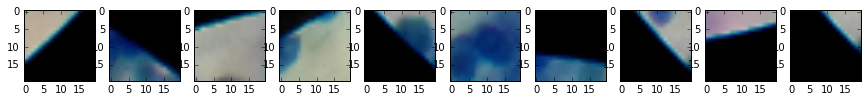

In [334]:
pos_indices = y_pred[:,1].argsort()
#pos_indices = pos_indices[::-1]

N_samples_to_display = 10

for i in range(N_samples_to_display,2*N_samples_to_display):
    plt.subplot(2,N_samples_to_display,i+1)
    example_neg = test_X[pos_indices[i],:,:,:]
    example_neg = np.swapaxes(example_neg,0,2)
    plt.imshow(example_neg[:,:,[2,1,0]])

plt.gcf().set_size_inches(1.5*N_samples_to_display,3) 

## Object detection in an entire field of view

In [358]:
imfile = opts['img_dir'] + testfiles[5]
found = det.detect(imfile, cnn, opts)

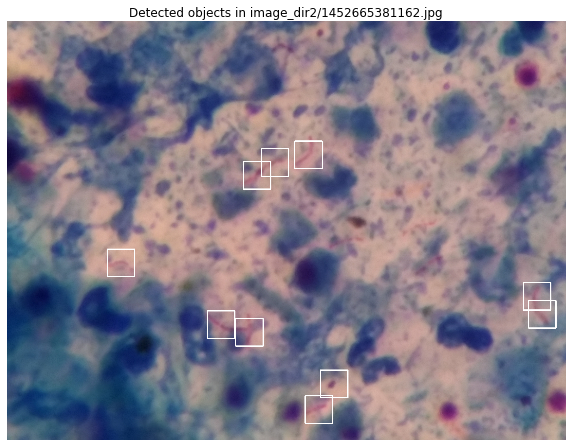

In [359]:
im = cv2.imread(imfile)

plt.box(False)
plt.xticks([])
plt.yticks([])

for f in found:
    f = f.astype(int)
    cv2.rectangle(im, (f[0], f[1]), (f[2],f[3]), (255,255,255), 6)
    
plt.gcf().set_size_inches(10,10)
plt.title('Detected objects in %s' % (imfile))
plt.imshow(im[:,:,[2,1,0]])